In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d bhanuprasanna/isic-2019
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


100% 5.20G/5.20G [00:48<00:00, 265MB/s]
100% 5.20G/5.20G [00:48<00:00, 116MB/s]


In [ ]:
import zipfile
import os

zip_file_path = "/content/skin-cancer-mnist-ham10000.zip"

extracted_dir_path = "skin-cancer-mnist-ham10000"

if not os.path.exists(extracted_dir_path):
    os.makedirs(extracted_dir_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import cv2
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
skinDf = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Set image size
img_size = (64, 64)

In [ ]:
# Encode labels
labelEncoder = LabelEncoder()
skinDf['label'] = labelEncoder.fit_transform(skinDf['dx'])

# Resampled to balance classes
dfs_by_label_resampled = {}
n_samples = 800
for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    dfs_by_label_resampled[label] = df_label_resampled
balanced_df = pd.concat(dfs_by_label_resampled.values()).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
!pip install Pillow
from PIL import Image

In [ ]:
imgPath = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/content/skin-cancer-mnist-ham10000/', '*', '*.jpg'))}
balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(img_size)) / 255)

# Split data
x = np.asarray(balanced_df['image'].to_list())
y = to_categorical(balanced_df['label'], num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True)

In [ ]:
# Model define
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(64, 64, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(rate=0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')
])

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train model
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_test, y_test), callbacks=[reduce_lr])


Epoch 1/200
560/560 [==============================] - 10s 9ms/step - loss: 0.2153 - accuracy: 0.9366 - val_loss: 0.3434 - val_accuracy: 0.8830 - lr: 1.0000e-05
Epoch 2/200
560/560 [==============================] - 4s 8ms/step - loss: 0.2069 - accuracy: 0.9386 - val_loss: 0.3478 - val_accuracy: 0.8795 - lr: 1.0000e-05
Epoch 3/200
560/560 [==============================] - 5s 9ms/step - loss: 0.2038 - accuracy: 0.9424 - val_loss: 0.3521 - val_accuracy: 0.8821 - lr: 1.0000e-05
Epoch 4/200
560/560 [==============================] - 4s 8ms/step - loss: 0.2103 - accuracy: 0.9382 - val_loss: 0.3435 - val_accuracy: 0.8795 - lr: 1.0000e-05
Epoch 5/200
560/560 [==============================] - 4s 8ms/step - loss: 0.1941 - accuracy: 0.9451 - val_loss: 0.3516 - val_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 6/200
560/560 [==============================] - 5s 9ms/step - loss: 0.1997 - accuracy: 0.9391 - val_loss: 0.3505 - val_accuracy: 0.8795 - lr: 1.0000e-05
Epoch 7/200
560/560 [==================

In [ ]:
# Evaluating model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

35/35 [==============================] - 1s 6ms/step - loss: 0.4404 - accuracy: 0.8839
Test Accuracy: 0.8839285969734192
Test Loss: 0.4403652846813202


In [ ]:
model.save('my_skin_disease_pred_model.h5')

print("Model training complete and saved!")

Model training complete and saved!


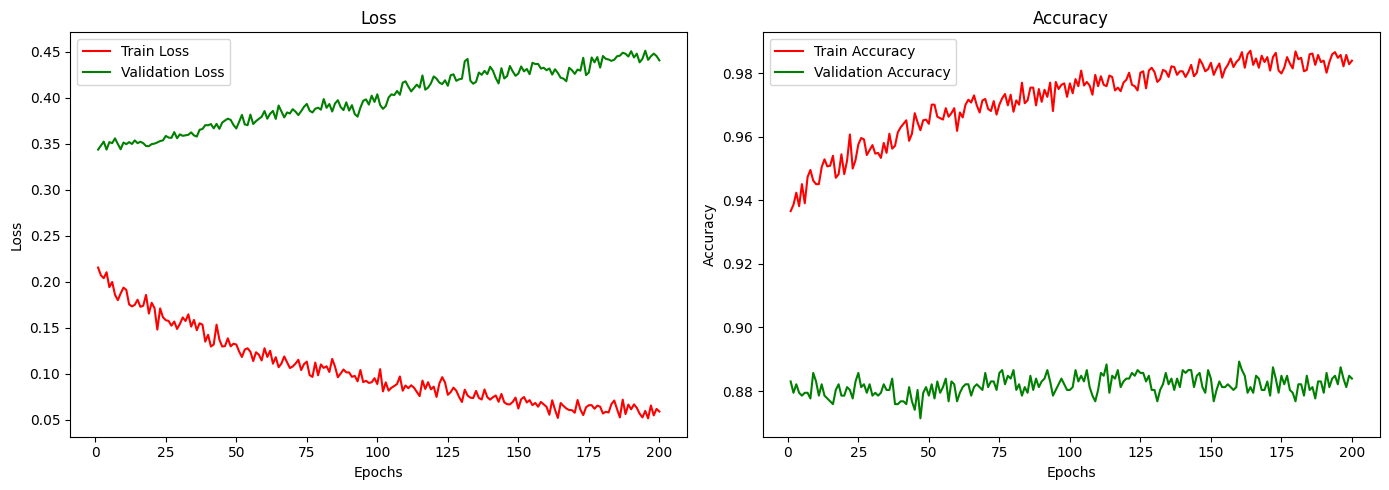

In [ ]:
# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

model = load_model('my_skin_disease_pred_model.h5')

def predict_image(image_path):
  """
  Predicts the class of an image using the loaded model.

  Args:
      image_path: Path to the image file.

  Returns:
      A list containing the predicted class label and its probability.
  """
  image = cv2.imread(image_path)

  # Preprocess image (resize and normalize)
  image = cv2.resize(image, (64, 64))
  image = image.astype('float32') / 255.0

  image = np.expand_dims(image, axis=0)

  predictions = model.predict(image)

  predicted_class = np.argmax(predictions[0])
  predicted_prob = predictions[0][predicted_class]

  return [predicted_class, predicted_prob]

image_to_predict = "/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024506.jpg"
predicted_class, predicted_prob = predict_image(image_to_predict)

print(f"Predicted class: {predicted_class}")
print(f"Predicted probability: {predicted_prob:.2f}")


1/1 [==============================] - 0s 141ms/step
Predicted class: 5
Predicted probability: 0.83


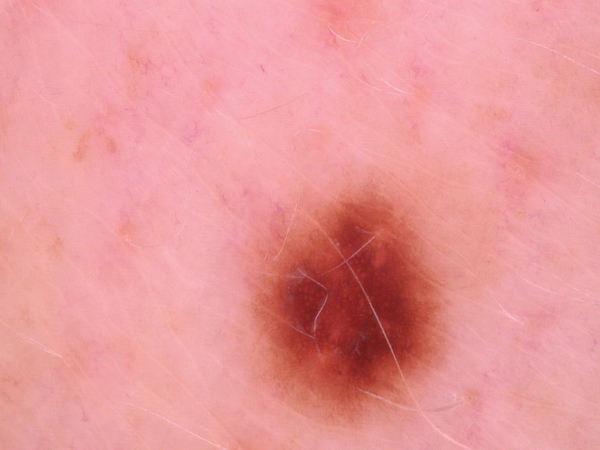

In [ ]:
from IPython.display import Image
Image(filename='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024506.jpg')


1/1 [==============================] - 0s 466ms/step


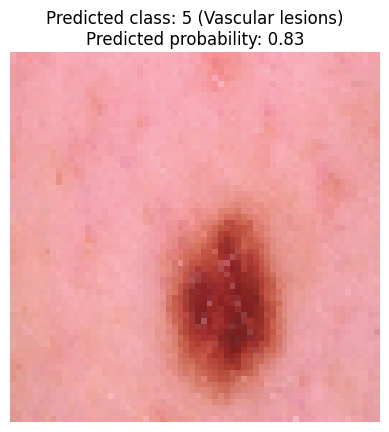

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

model = load_model('my_skin_disease_pred_model.h5')

class_names = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

def predict_image(image_path):
    """
    Predicts the class of an image using the loaded model.

    Args:
        image_path: Path to the image file.

    Returns:
        A tuple containing the predicted class label, its name, and its probability.
    """
    image = cv2.imread(image_path)

    # Preprocess image (resize and normalize)
    image = cv2.resize(image, (64, 64))
    image = image.astype('float32') / 255.0

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)

    predicted_class_index = np.argmax(predictions[0])
    predicted_prob = predictions[0][predicted_class_index]
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_index, predicted_class_name, predicted_prob, image[0]

image_to_predict = "/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024506.jpg"
predicted_class_index, predicted_class_name, predicted_prob, image = predict_image(image_to_predict)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class_index} ({predicted_class_name})\nPredicted probability: {predicted_prob:.2f}")
plt.axis('off')
plt.show()



In [ ]:
!pip install tensorflowjs
# import tensorflowjs as tfjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
  Attempting uninstall: ml-dtypes
 

In [ ]:
import tensorflowjs as tfjs

In [ ]:
from keras.models import load_model

model = load_model('/content/my_skin_disease_pred_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
 tfjs.converters.save_keras_model(model, '/content/')

failed to lookup keras version from the file,
    this is likely a weight only file
